In [1]:
import sys
sys.path.append("/home/stachu/Projects/Anomaly_detection/Forecasting_models")

from predpy.dataset import TimeSeriesRecordsDataset
from predpy.dataset import SingleTimeSeriesDataset, MultiTimeSeriesDataset
from predpy.data_module import MultiTimeSeriesModule
from predpy.experimentator import (
    DatasetParams, ModelParams, ExperimentatorPlot,
    Experimentator, load_experimentator, plot_aggregated_predictions)
from predpy.preprocessing import set_index
from predpy.preprocessing import moving_average
from predpy.preprocessing import (
    load_and_preprocess, set_index, moving_average, drop_if_is_in,
    use_dataframe_func, loc, iloc)
from predpy.trainer import (
    CheckpointParams, TrainerParams, EarlyStoppingParams, LoggerParams)
from tsad.noiser import apply_noise_on_dataframes, white_noise

import pickle
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tsai.models import TCN, ResNet, TST, RNN, TransformerModel, FCN
import pandas as pd
from pytorch_lightning.loggers import TensorBoardLogger
from torch.utils.data import DataLoader

In [2]:
window_size = 366

load_params = {
    "sep": ';', "header": 0, "low_memory": False,
    "infer_datetime_format": True, "parse_dates": {'datetime': [0, 1]},
    "index_col": ['datetime']
}

columns = ["Global_active_power", "Voltage"]
drop_refill_pipeline = [
    (loc, {"columns": columns}),
    (drop_if_is_in, (["?", np.nan]), {"columns": columns}),
    # (iloc, {"rows_end": 1500}),
    # (iloc, {"rows_start": -20000}),
]
preprocessing_pipeline = [
    (use_dataframe_func, "astype", "float"),
]
datasets_params = [
    DatasetParams(
        path="/home/stachu/Projects/Anomaly_detection/Forecasting_models/data/Energy/household_power_consumption/household_power_consumption.csv",
        load_params=load_params,
        target="Global_active_power",
        split_proportions=[0.8, 0.1, 0.1],
        window_size=window_size,
        batch_size=64,
        DatasetCls=MultiTimeSeriesDataset,
        drop_refill_pipeline=drop_refill_pipeline,
        preprocessing_pipeline=preprocessing_pipeline,
        scaler=MinMaxScaler()),
]

c_in = 2
c_out = 1

models_params = [
    # ModelParams(
    #     name_="TST_l3_fcDrop0.1", cls_=TST.TST,
    #     init_params={
    #         "c_in": c_in, "c_out": c_out, "seq_len": window_size,
    #         "max_seq_len": window_size, "n_layers": 3, "fc_dropout": 0.1}),
    # ModelParams(
    #     name_="TST_l2_fcDrop0.1", cls_=TST.TST,
    #     init_params={
    #         "c_in": c_in, "c_out": c_out, "seq_len": window_size,
    #         "max_seq_len": window_size, "n_layers": 2, "fc_dropout": 0.1}),
    # ModelParams(
    #     name_="TST_l2_fcDrop0.0", cls_=TST.TST,
    #     init_params={
    #         "c_in": c_in, "c_out": c_out, "seq_len": window_size,
    #         "max_seq_len": window_size, "n_layers": 2, "fc_dropout": 0.0}),
    # ModelParams(
    #     name_="ResNet", cls_=ResNet.ResNet,
    #     init_params={"c_in": c_in, "c_out": c_out}),
    ModelParams(
        name_="LSTM_h200_l1", cls_=RNN.LSTM,
        init_params={
            "c_in": c_in, "c_out": c_out, "hidden_size": 200, "n_layers": 1}),
    # ModelParams(
    #     name_="LSTM_h200_l2", cls_=RNN.LSTM,
    #     init_params={
    #         "c_in": c_in, "c_out": c_out, "hidden_size": 200, "n_layers": 2}),
    # ModelParams(
    #     name_="LSTM_h400_l1", cls_=RNN.LSTM,
    #     init_params={
    #         "c_in": c_in, "c_out": c_out, "hidden_size": 400, "n_layers": 1}),
]

chp_p = CheckpointParams(
    dirpath="../checkpoints", monitor='val_loss', verbose=True,
    save_top_k=1)
tr_p = TrainerParams(
    max_epochs=1, gpus=1, auto_lr_find=True,
    logger=TensorBoardLogger("../lightning_logs"))
es_p = EarlyStoppingParams(
    monitor='val_loss', patience=2, verbose=True)

In [3]:
# exp = Experimentator(
#     models_params=models_params,
#     datasets_params=datasets_params,
#     trainer_params=tr_p,
#     checkpoint_params=chp_p,
#     early_stopping_params=es_p
# )

# exp.run_experiments(experiments_path="../saved_experiments", safe=False)

exp = load_experimentator(
    "../saved_experiments/2021-12-11_16:34:50.pkl")

In [4]:
tsm = exp.load_time_series_module(0)
normal_dfs = tsm.get_data_from_range(start=-1000, end=-500, copy=True)
anomaly_dfs = tsm.get_data_from_range(start=-500, copy=True)

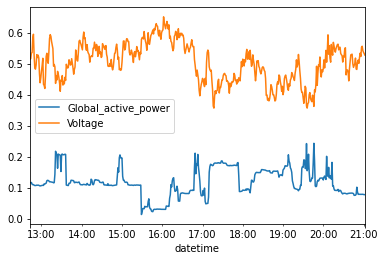

In [5]:
anomaly_dfs[0].plot();

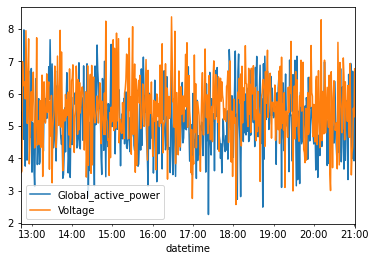

In [6]:
apply_noise_on_dataframes(
    anomaly_dfs, make_noise=white_noise, negativity="abs", loc=5, scale=1.0)
anomaly_dfs[0].plot();

In [7]:
from tsad.anomaly_detector import PredictionAnomalyDetector

model = exp.load_pl_model(
    model_idx=0,
    dir_path="../checkpoints/household_power_consumption/LSTM_h200_l1")

ad = PredictionAnomalyDetector(model)

ad.fit(
    train_data=DataLoader(
        MultiTimeSeriesDataset(normal_dfs, tsm.window_size, tsm.target),
        batch_size=tsm.batch_size),
    anomaly_data=DataLoader(
        MultiTimeSeriesDataset(anomaly_dfs, tsm.window_size, tsm.target),
        batch_size=tsm.batch_size),
    normal_data=DataLoader(
        MultiTimeSeriesDataset(normal_dfs, tsm.window_size, tsm.target),
        batch_size=tsm.batch_size),
    class_weight=None, verbose=True, plot=True
)

ad.find_anomalies(tsm.test_dataloader())

Time series predictions: 100%|██████████| 3/3 [00:00<00:00,  9.25it/s]


[[130   4]
 [  0 134]]


KeyboardInterrupt: 

Time series predictions: 100%|██████████| 3/3 [00:00<00:00,  9.84it/s]


(array([[  4.,   6.,   1.,   5.,  20.,  30.,  21.,  15.,   9.,   5.,   0.,
           3.,   0.,   4.,   2.,   0.,   2.,   1.,   2.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   1.,   0.,   0.,   3.],
        [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0., 134.]]),
 array([0.28184315, 0.30578172, 0.32972028, 0.35365884, 0.3775974 ,
        0.40153596, 0.42547452, 0.44941308, 0.47335165, 0.49729021,
        0.52122877, 0.54516733, 0.56910589, 0.59304445, 0.61698302,
        0.64092158, 0.66486014, 0.6887987 , 0.71273726, 0.73667582,
        0.76061438, 0.78455295, 0.80849151, 0.83243007, 0.85636863,
        0.88030719, 0.90424575, 0.92818432, 0.95212288, 0.97606144,
        1.        ]),
 <a list of 2 BarContainer objects>)

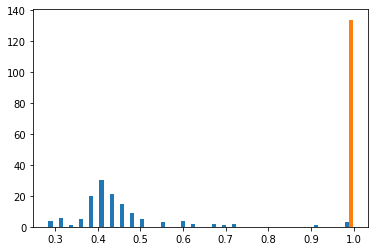

In [17]:
import numpy as np
import matplotlib.pyplot as plt


anomaly_data=DataLoader(
    MultiTimeSeriesDataset(anomaly_dfs, tsm.window_size, tsm.target),
    batch_size=tsm.batch_size)
normal_data=DataLoader(
    MultiTimeSeriesDataset(normal_dfs, tsm.window_size, tsm.target),
    batch_size=tsm.batch_size)
normal_preds = ad._any_forward(normal_data, True)
anomaly_preds = ad._any_forward(anomaly_data, True)
plt.hist([
    ad.distributor.cdf(normal_preds).T[0], ad.distributor.cdf(anomaly_preds).T[0]],
    bins=30, label=["normal", "anomaly"]);

In [19]:
ad.distributor.cdf(anomaly_preds).T[0]

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.98452

In [ ]:
ad.thresholder.predict_proba([[0.7389222968963186]])

array([[0.5, 0.5]])

In [ ]:
th = -ad.thresholder.intercept_[0] / ad.thresholder.coef_[0, 0]
th

0.7389222968963186

In [ ]:
# BTC = yf.Ticker("BTC-USD")
# # df = BTC.history(period="max", interval="1d", auto_adjust=False, actions=False)
# df = BTC.history(interval="1d", start="2014-09-17", end="2021-10-16", actions=False)
# df["Open-Close-diff"] = df.apply(lambda x: x["Close"] - x["Open"], axis=1)

# from datetime import datetime
# end = datetime.strptime("06-01-2017", '%m-%d-%Y')
# df = df.loc[:end]  # remove last years due to a change behaviour
# df = df[["Close", "Open-Close-diff"]]